In [ ]:
%%capture
# Install required packages
!pip install -U transformers faiss-gpu torch Pillay tqdm ipywidgets
!pip install -U git+https://github.com/360CVGroup/FG-CLIP.git


In [29]:
import torch
import faiss
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from transformers import AutoProcessor, AutoModel
import matplotlib.pyplot as plt

# Configuration
IMAGE_ROOT = Path("images")
MODEL_NAME = "qihoo360/fg-clip-large"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
INDEX_CONFIG = {
    "nlist": 256,          # Number of IVF clusters
    "nprobe": 16,          # Number of clusters to search
    "metric": faiss.METRIC_INNER_PRODUCT
}


In [2]:
def load_image_paths():
    """Load all images with location metadata"""
    locations = []
    image_paths = []
    
    for loc_dir in IMAGE_ROOT.iterdir():
        if loc_dir.is_dir():
            loc_id = loc_dir.name
            for img_path in loc_dir.glob("*.*"):
                if img_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
                    image_paths.append(img_path)
                    locations.append(loc_id)
    
    return image_paths, locations

# Initialize FG-CLIP model
processor = AutoProcessor.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE).eval()

def generate_embeddings(image_paths, batch_size=BATCH_SIZE):
    """Generate FG-CLIP embeddings with batch processing"""
    embeddings = []
    
    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i+batch_size]
        images = [Image.open(p).convert("RGB") for p in batch_paths]
        
        with torch.no_grad():
            inputs = processor(images=images, return_tensors="pt", padding=True)
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            features = model.get_image_features(**inputs)
            features = torch.nn.functional.normalize(features, dim=-1)
            embeddings.append(features.cpu().numpy())
    
    return np.concatenate(embeddings)

# Load and process all images
image_paths, location_ids = load_image_paths()
embeddings = generate_embeddings(image_paths)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


  0%|          | 0/59 [00:00<?, ?it/s]

In [3]:
import os
import pickle

def create_faiss_index(embeddings):
    """Create optimized FAISS index for FG-CLIP embeddings"""
    d = embeddings.shape[1]
    
    quantizer = faiss.IndexFlatIP(d)
    index = faiss.IndexIVFFlat(quantizer, d, INDEX_CONFIG["nlist"])
    
    # Train with 20% sample
    np.random.seed(42)
    sample_idx = np.random.choice(
        len(embeddings), 
        size=int(0.2*len(embeddings)), 
        replace=False
    )
    index.train(embeddings[sample_idx])
    
    index.add(embeddings)
    index.nprobe = INDEX_CONFIG["nprobe"]
    return index

index = create_faiss_index(embeddings)


# Embeddings save
def save_embeddings(embeddings, filename='fgclip_embeddings.npy'):
    np.save(filename, embeddings)
    print(f"Embeddings saved to {filename}")

def load_embeddings(filename='fgclip_embeddings.npy'):
    if os.path.exists(filename):
        embeddings = np.load(filename)
        print(f"Embeddings loaded from {filename}, shape: {embeddings.shape}")
        return embeddings
    else:
        print(f"File {filename} not found.")
        return None
    
# FAISS Index
def save_faiss_index(index, filename='faiss_index.index'):
    faiss.write_index(index, filename)
    print(f"FAISS index saved to {filename}")

def load_faiss_index(filename='faiss_index.index'):
    if os.path.exists(filename):
        index = faiss.read_index(filename)
        print(f"FAISS index loaded from {filename}")
        return index
    else:
        print(f"File {filename} not found.")
        return None

# Metadata (image paths and location ids)
def save_metadata(image_paths, location_ids, filename='metadata.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump({'image_paths': image_paths, 'location_ids': location_ids}, f)
    print(f"Metadata saved to {filename}")

def load_metadata(filename='metadata.pkl'):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        print(f"Metadata loaded from {filename}")
        return data['image_paths'], data['location_ids']
    else:
        print(f"File {filename} not found.")
        return None, None

In [4]:
save_embeddings(embeddings, 'fgclip_embeddings.npy')
save_faiss_index(index, 'faiss_index.index')
save_metadata(image_paths, location_ids, 'metadata.pkl')


Embeddings saved to fgclip_embeddings.npy
FAISS index saved to faiss_index.index
Metadata saved to metadata.pkl


In [25]:
class LocationRetrievalSystem:
    def __init__(self, index, image_paths, location_ids):
        self.index = index
        self.image_paths = image_paths
        self.locations = location_ids
        self.loc_db = {path: loc for path, loc in zip(image_paths, location_ids)}
        
    def _search(self, query_emb, k=10):
        """Core search functionality"""
        distances, indices = self.index.search(query_emb, k)
        return [
            (self.image_paths[i], distances[0][j], self.loc_db[self.image_paths[i]])
            for j, i in enumerate(indices[0])
        ]
    
    def query_image(self, image_path, k=10):
        """Search by image query"""
        query_emb = generate_embeddings([image_path])
        return self._search(query_emb, k)
    
    def query_text(self, text, k=10):
        """Search by text query"""
        with torch.no_grad():
            inputs = processor(text=text, return_tensors="pt", padding=True)
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            features = model.get_text_features(**inputs)
            features = torch.nn.functional.normalize(features, dim=-1)
            query_emb = features.cpu().numpy()
        
        return self._search(query_emb, k)
    
    def show_results(self, results):
        """Visualize top results with location metadata"""
        plt.figure(figsize=(20, 10))
        for i, (path, score, loc) in enumerate(results[:5]):
            plt.subplot(1, 5, i+1)
            plt.imshow(Image.open(path))
            plt.title(f"Location: {loc}\nScore: {score:.3f}")
            plt.axis('off')
        plt.show()



In [26]:
def location_aggregation(results):
    """Group results by location and calculate aggregate scores"""
    from collections import defaultdict
    loc_scores = defaultdict(list)
    
    for path, score, loc in results:
        loc_scores[loc].append(score)
    
    # Calculate weighted average (exponential decay)
    return sorted([
        (loc, np.mean(scores) * np.log1p(len(scores)))
        for loc, scores in loc_scores.items()
    ], key=lambda x: -x[1])

def rerank_by_color(query_image, results):
    """Secondary ranking using color histograms"""
    # Implement CIEDE2000 color difference calculation
    # (Requires additional color processing logic)
    pass


In [27]:
# load saved data
embeddings = load_embeddings('fgclip_embeddings.npy')
index = load_faiss_index('faiss_index.index')
image_paths, location_ids = load_metadata('metadata.pkl')

# Initiate retrieval system
retrieval_system = LocationRetrievalSystem(index, image_paths, location_ids)


Embeddings loaded from fgclip_embeddings.npy, shape: (1858, 768)
FAISS index loaded from faiss_index.index
Metadata loaded from metadata.pkl


Searching for driveway for a car


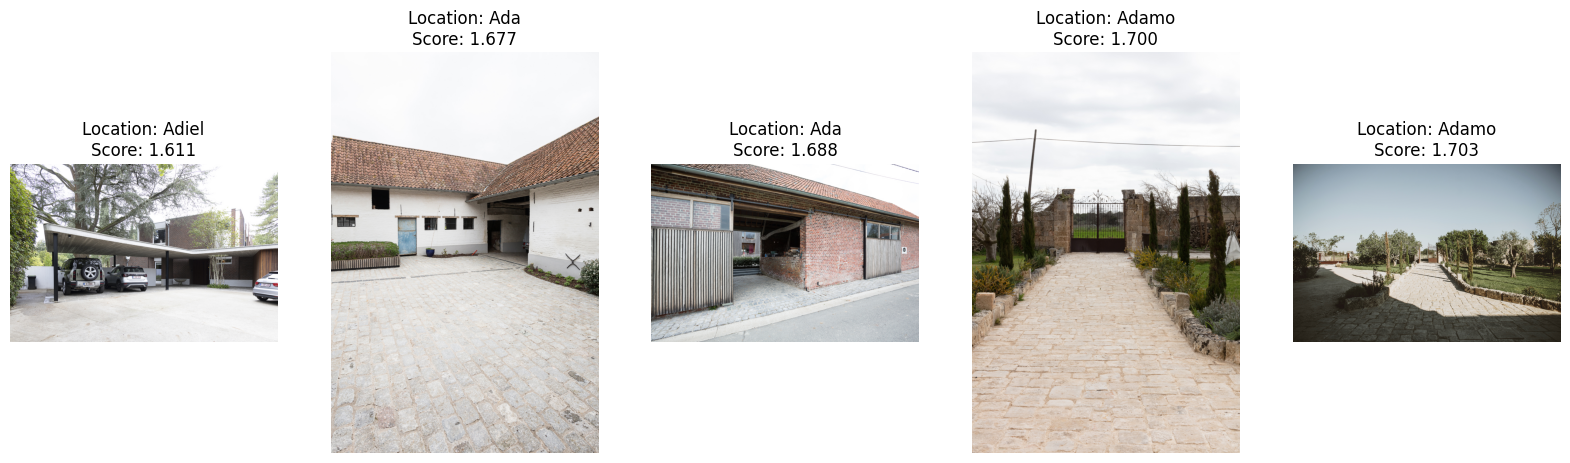

Top Locations:
Aldo: 1.897
Adamo: 1.869
Ada: 1.848
Searching similar to images\Aaron\AARON_StudioScott_-0658_LR.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

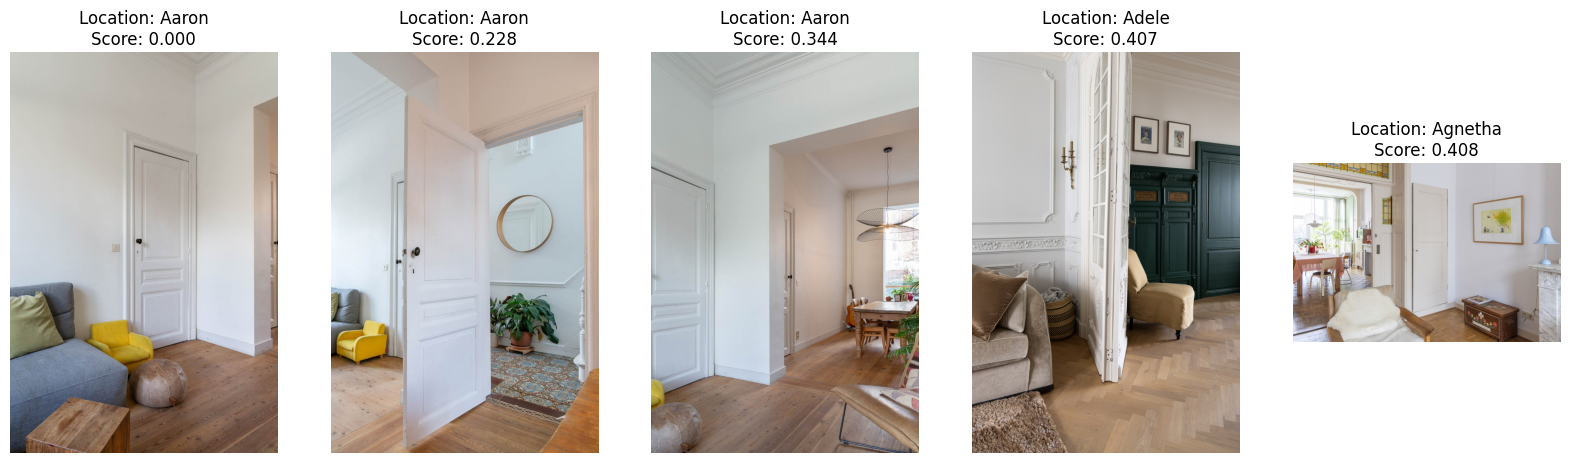

In [31]:
# Text Query Example
query = "driveway for a car" # try driveway for a car, yellow chair
print(f"Searching for {query}")
results = retrieval_system.query_text(query)
retrieval_system.show_results(results)

# Location-based Aggregation
aggregated = location_aggregation(results)
print("Top Locations:")
for loc, score in aggregated[:3]:
    print(f"{loc}: {score:.3f}")

# Image Query Example
sample_image = "images\Aaron\AARON_StudioScott_-0658_LR.jpg"
print(f"Searching similar to {sample_image}")
results = retrieval_system.query_image(sample_image)
retrieval_system.show_results(results)